# Loading data from Simulations

In [2]:
import os
import re
import pandas as pd
import numpy as np
from io import StringIO

input_folder_name = "QSTest_normal" # folder name within data/cluster/endsim
output_folder_name = input_folder_name

# Updated regex pattern to handle all cases
pattern = r"EndSim_epsM(-?[\d\.]+)_epsSD(-?[\d\.]+)___OpDnormal_OpM(-?[\d\.]+)_OpSD(-?[\d\.]+)___NetScale-free___NAgents1000___RS\d+___MedDdeterministic-normal_MedN20_MedM(-?[\d\.]+)_MedSD(-?[\d\.]+)"
def parse_filename(filename):
    """Extract parameters from filename using regex"""
    # Remove .csv extension before parsing
    base_name = os.path.splitext(filename)[0]
    match = re.search(pattern, base_name)
    if match:
        return {
            'epsM': float(match.group(1)),
            'epsSD': float(match.group(2)),
            'OpM': float(match.group(3)),
            'OpSD': float(match.group(4)),
            'MedM': float(match.group(5)),
            'MedSD': float(match.group(6))
        }
    return None

def extract_opinion_sections(content):
    """Extract media and individual opinion sections from file content"""
    # Split content into sections using separator lines
    sections = re.split(r'-{10,}', content)
    
    # We expect at least 4 sections:
    # 0: Metadata
    # 1: Network connections (skip)
    # 2: Media opinions
    # 3: Individual opinions
    if len(sections) < 4:
        return None, None
    
    # Extract media opinions section
    media_section = sections[2].strip()
    # Extract individual opinions section
    individual_section = sections[3].strip()
    
    return media_section, individual_section

def parse_opinion_section(section):
    """Parse a single opinion section into a DataFrame"""
    if not section:
        return pd.DataFrame()
    
    # Clean section by removing any empty lines and brackets
    cleaned_lines = []
    for line in section.split('\n'):
        if line.strip() and not line.startswith('[') and not line.startswith('--'):
            cleaned_lines.append(line)
    
    if not cleaned_lines:
        return pd.DataFrame()
    
    # Recreate CSV content
    csv_content = "\n".join(cleaned_lines)
    
    # Parse as CSV
    try:
        return pd.read_csv(StringIO(csv_content))
    except:
        return pd.DataFrame()

def process_simulation_file(filepath):
    """Process a single simulation file with section handling"""
    # Extract parameters from filename
    filename = os.path.basename(filepath)
    params = parse_filename(filename)
    if not params:
        print(f"Skipping {filename} - pattern not matched")
        return None
    
    try:
        # Read entire file content
        with open(filepath, 'r') as f:
            content = f.read()
        # Extract opinion sections
        media_section, individual_section = extract_opinion_sections(content)

        # Parse media opinions
        media_df = parse_opinion_section(media_section)

        media_opinions = []
        # print(media_df.columns)

        if not media_df.empty and ' opinion)' in media_df:
            media_opinions = media_df[' opinion)'].apply(
                lambda x: float(str(x).strip('[]'))).values
        
        # Parse individual opinions
        individual_df = parse_opinion_section(individual_section)
        individual_opinions = []
        if not individual_df.empty and 'opinion' in individual_df:
            individual_opinions = individual_df['opinion'].apply(
                lambda x: float(str(x).strip('[]'))).values
        
        # Add to params
        params['individual_opinions'] = np.array(individual_opinions)
        params['media_opinions'] = np.array(media_opinions)
        
        # Add static parameters
        params['NAgents'] = 1000
        params['MedN'] = 20
        params['NetType'] = "scale-free"
        params['ScaleFreeDegree'] = 1
        
        return params
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        return None

def load_all_simulations(directory):
    """Process all simulation files in a directory"""
    all_data = []
    processed_count = 0
    skipped_count = 0
    error_count = 0
    
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            result = process_simulation_file(filepath)
            if result:
                all_data.append(result)
                processed_count += 1
            else:
                skipped_count += 1
    
    print(f"Summary: Processed={processed_count}, Skipped={skipped_count}")
    return pd.DataFrame(all_data) if all_data else pd.DataFrame()

# Example usage
if __name__ == "__main__":
    simulations_df = load_all_simulations("data\\cluster\\endsim\\" + input_folder_name)
    
    if not simulations_df.empty:
        print(f"\nSuccessfully loaded {len(simulations_df)} simulations")
        print("Parameter ranges:")
        for param in ['epsM', 'epsSD', 'OpM', 'OpSD', 'MedM', 'MedSD']:
            values = simulations_df[param]
            print(f"{param}: min={values.min()}, max={values.max()}")
        
        # Show example opinion data
        sample = simulations_df.iloc[0]
        print(f"\nSample simulation opinions:")
        print(f"Individual opinions: {len(sample['individual_opinions'])} values")
        print(f"Media opinions: {len(sample['media_opinions'])} values")
    else:
        print("No simulations loaded. Please check file patterns and data quality.")

Summary: Processed=3375, Skipped=0

Successfully loaded 3375 simulations
Parameter ranges:
epsM: min=0.01, max=0.41
epsSD: min=0.0, max=0.5
OpM: min=-1.0, max=1.0
OpSD: min=0.0, max=0.5
MedM: min=-1.0, max=1.0
MedSD: min=0.0, max=0.5

Sample simulation opinions:
Individual opinions: 1000 values
Media opinions: 20 values


In [2]:
simulations_df

,epsM,epsSD,OpM,OpSD,MedM,MedSD,individual_opinions,media_opinions,NAgents,MedN,NetType,ScaleFreeDegree
0,0.01,0.25,-0.5,0.25,-0.5,0.25,"[-0.486, -0.5, -0.5, -0.498, -0.5, -0.499, -0....","[-0.57568359375, -0.4549560546875, -0.23315429...",1000,20,scale-free,1
1,0.01,0.25,-0.5,0.25,-0.5,0.50,"[-0.588, -0.553, -0.56, -0.47, -0.476, -0.468,...","[-0.06201171875, -0.409912109375, -0.143798828...",1000,20,scale-free,1
2,0.01,0.25,-0.5,0.25,-0.5,0.00,"[-0.157, -0.501, -0.5, -0.488, -0.5, -0.5, -0....","[-0.508758544921875, -0.49697113037109375, -0....",1000,20,scale-free,1
3,0.01,0.25,-0.5,0.25,-1.0,0.25,"[-0.926, -0.84, -0.927, -0.41, -0.584, -0.91, ...","[-1.0, -1.0, -1.0, -1.0, -0.5830078125, -0.985...",1000,20,scale-free,1
4,0.01,0.25,-0.5,0.25,-1.0,0.50,"[-0.888, -0.609, -0.88, -0.804, -0.88, -0.326,...","[-1.0, -0.8486328125, -0.643798828125, -0.9099...",1000,20,scale-free,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3370,0.41,0.00,1.0,0.00,0.0,0.50,"[0.044, 0.044, 0.044, 0.044, 0.044, 0.044, 0.0...","[-0.090087890625, 0.090087890625, 0.0297851562...",1000,20,scale-free,1
3371,0.41,0.00,1.0,0.00,0.0,0.00,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-0.013092041015625, -0.016693115234375, -0.00...",1000,20,scale-free,1
3372,0.41,0.00,1.0,0.00,1.0,0.25,"[0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.9...","[0.9549560546875, 1.0, 0.985107421875, 1.0, 0....",1000,20,scale-free,1
3373,0.41,0.00,1.0,0.00,1.0,0.50,"[0.821, 0.821, 0.821, 0.821, 0.821, 0.821, 0.8...","[0.643798828125, 0.46630859375, 1.0, 0.7846679...",1000,20,scale-free,1


## Binning Simulation Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define bin edges for 10-point scale mapping
bin_edges = np.array([-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Create bin interval labels for display
bin_intervals = [
    "[-1.0, -0.8)",
    "[-0.8, -0.6)",
    "[-0.6, -0.4)",
    "[-0.4, -0.2)",
    "[-0.2, 0.0)",
    "[0.0, 0.2)",
    "[0.2, 0.4)",
    "[0.4, 0.6)",
    "[0.6, 0.8)",
    "[0.8, 1.0]"
]

def bin_opinions(opinions):
    """Bin opinions into 10-point scale categories"""
    # Digitize opinions (returns bin indices 1-10)
    bin_indices = np.digitize(opinions, bin_edges[1:-1], right=False)
    return bin_indices

def bin_distribution(opinions):
    """Compute normalized distribution across bins"""
    counts, _ = np.histogram(opinions, bins=bin_edges)
    return counts / counts.sum()

# Add binned opinions and distributions to DataFrame
simulations_df['binned_opinions'] = simulations_df['individual_opinions'].apply(
    lambda x: bin_opinions(np.array(x))
)

simulations_df['binned_distribution'] = simulations_df['individual_opinions'].apply(
    lambda x: bin_distribution(np.array(x))
)

# Add bin interval labels as a constant column
simulations_df['bin_intervals'] = [bin_intervals] * len(simulations_df)

# Display the updated DataFrame
print("\nDataFrame with binned opinions:")
print(simulations_df[['epsM', 'epsSD', 'OpM', 'OpSD', 'MedM', 'MedSD', 
                      'binned_opinions', 'binned_distribution', 'bin_intervals']].head())


DataFrame with binned opinions:
   epsM  epsSD  OpM  OpSD  MedM  MedSD  \
0  0.01   0.25 -0.5  0.25  -0.5   0.25   
1  0.01   0.25 -0.5  0.25  -0.5   0.50   
2  0.01   0.25 -0.5  0.25  -0.5   0.00   
3  0.01   0.25 -0.5  0.25  -1.0   0.25   
4  0.01   0.25 -0.5  0.25  -1.0   0.50   

                                     binned_opinions  \
0  [2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 1, 2, 2, ...   
1  [2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 2, ...   
2  [4, 2, 2, 2, 2, 2, 2, 2, 5, 3, 4, 4, 2, 2, 2, ...   
3  [0, 0, 0, 2, 2, 0, 0, 4, 0, 0, 2, 3, 3, 0, 0, ...   
4  [0, 1, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 1, 1, 0, ...   

                                 binned_distribution  \
0  [0.012, 0.05, 0.875, 0.04, 0.016, 0.005, 0.002...   
1  [0.038, 0.178, 0.659, 0.094, 0.026, 0.005, 0.0...   
2  [0.033, 0.049, 0.818, 0.052, 0.038, 0.008, 0.0...   
3  [0.747, 0.052, 0.059, 0.087, 0.045, 0.008, 0.0...   
4  [0.653, 0.121, 0.123, 0.07, 0.026, 0.005, 0.00...   

                                       b

## Pooled Sim Data Histogram


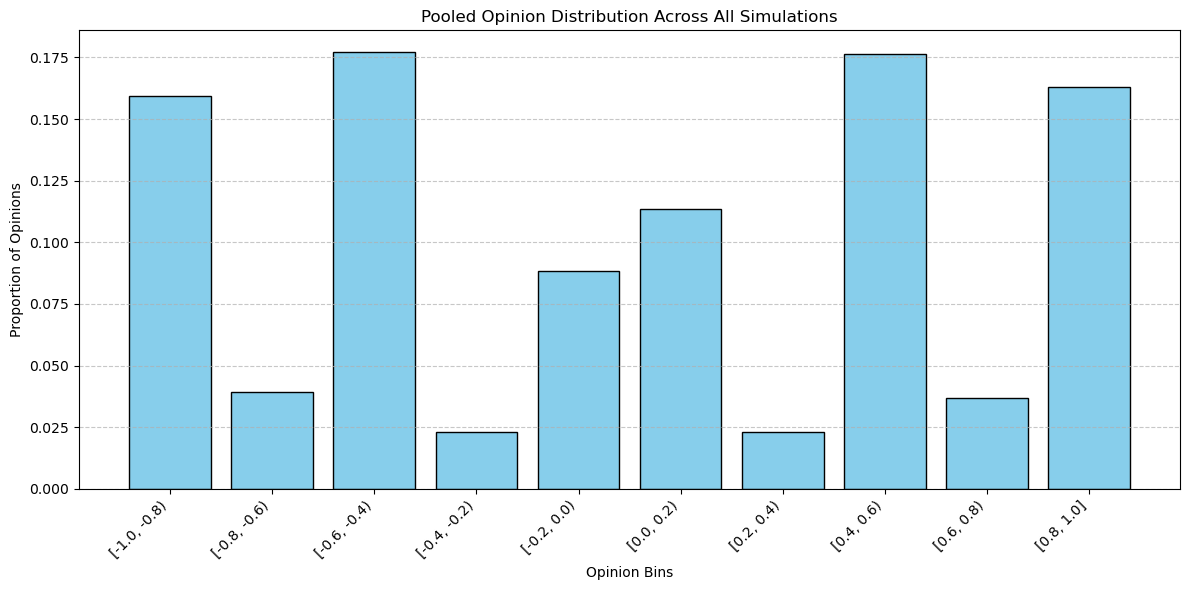

In [4]:
# Create pooled histogram of all opinions
all_opinions = np.concatenate(simulations_df['individual_opinions'].values)
pooled_counts, _ = np.histogram(all_opinions, bins=bin_edges)
pooled_distribution = pooled_counts / pooled_counts.sum()

# Plot the pooled histogram
plt.figure(figsize=(12, 6))
plt.bar(range(1, 11), pooled_distribution, color='skyblue', edgecolor='black')
plt.xticks(range(1, 11), bin_intervals, rotation=45, ha='right')
plt.xlabel('Opinion Bins')
plt.ylabel('Proportion of Opinions')
plt.title('Pooled Opinion Distribution Across All Simulations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('pooled_opinion_distribution.png', dpi=300)
plt.show()


## Generate individual histograms for every run

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Create output directory
output_dir = "analysis/plots/endsim_distributions/" + output_folder_name
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Define bin edges and labels
bin_edges = np.array([-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bin_intervals = [
    "[-1.0, -0.8)", "[-0.8, -0.6)", "[-0.6, -0.4)", "[-0.4, -0.2)", 
    "[-0.2, 0.0)", "[0.0, 0.2)", "[0.2, 0.4)", "[0.4, 0.6)", 
    "[0.6, 0.8)", "[0.8, 1.0]"
]

# Function to create and save histograms
def save_simulation_histogram(row, index):
    """Create and save histogram for a single simulation"""
    # Extract parameters for title and filename
    params = {
        'epsM': row['epsM'],
        'epsSD': row['epsSD'],
        'OpM': row['OpM'],
        'OpSD': row['OpSD'],
        'MedM': row['MedM'],
        'MedSD': row['MedSD']
    }
    
    # Create filename with parameters
    filename = (
        f"sim_{index:04d}_"
        f"epsM{params['epsM']:.2f}_epsSD{params['epsSD']:.2f}_"
        f"OpM{params['OpM']:.2f}_OpSD{params['OpSD']:.2f}_"
        f"MedM{params['MedM']:.2f}_MedSD{params['MedSD']:.2f}.png"
    ).replace(".", "dot")  # Replace dots to avoid filesystem issues
    
    # Create title with parameters
    title = (
        f"Opinion Distribution: "
        f"εμ={params['epsM']:.2f}, εσ={params['epsSD']:.2f}, "
        f"Opμ={params['OpM']:.2f}, Opσ={params['OpSD']:.2f}, "
        f"Medμ={params['MedM']:.2f}, Medσ={params['MedSD']:.2f}"
    )
    
    # Create figure
    plt.figure(figsize=(12, 7))
    
    # Plot histogram
    n, bins, patches = plt.hist(
        row['individual_opinions'], 
        bins=bin_edges, 
        density=True, 
        alpha=0.7, 
        color='steelblue',
        edgecolor='black'
    )

    # Add vertical lines at media positions for reference
    for medop in row['media_opinions']:
        plt.axvline(medop, color='red', linestyle='--', alpha=0.5)
    
    # Format plot
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Opinion Value', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.xticks(bin_edges, rotation=45)
    plt.xlim(-1.05, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add bin labels
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    for i in range(len(bin_intervals)):
        plt.text(
            bin_centers[i], n[i] + 0.01, 
            f"{n[i]:.2f}\n{bin_intervals[i]}", 
            ha='center', va='bottom', fontsize=9
        )
    
    # Add statistics box
    stats_text = (
        f"N: {len(row['individual_opinions'])}\n"
    )
    
    plt.gcf().text(0.95, 0.85, stats_text, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.5))
    
    # Save and close
    plt.tight_layout()
    # plt.savefig(os.path.join(output_dir, filename), dpi=150)
    plt.close()
    return filename

# Generate histograms for all simulations
print(f"Generating {len(simulations_df)} histograms...")
for i, (index, row) in enumerate(simulations_df.iterrows()):
    if i % 100 == 0:  # Print progress every 100 files
        print(f"Processing simulation {i+1}/{len(simulations_df)}")
    save_simulation_histogram(row, index)

print(f"\nAll histograms saved to: {output_dir}")

Generating 3375 histograms...
Processing simulation 1/3375
Processing simulation 101/3375
Processing simulation 201/3375
Processing simulation 301/3375
Processing simulation 401/3375
Processing simulation 501/3375
Processing simulation 601/3375
Processing simulation 701/3375
Processing simulation 801/3375
Processing simulation 901/3375
Processing simulation 1001/3375
Processing simulation 1101/3375
Processing simulation 1201/3375
Processing simulation 1301/3375
Processing simulation 1401/3375
Processing simulation 1501/3375
Processing simulation 1601/3375
Processing simulation 1701/3375
Processing simulation 1801/3375
Processing simulation 1901/3375
Processing simulation 2001/3375
Processing simulation 2101/3375
Processing simulation 2201/3375
Processing simulation 2301/3375
Processing simulation 2401/3375
Processing simulation 2501/3375
Processing simulation 2601/3375
Processing simulation 2701/3375
Processing simulation 2801/3375
Processing simulation 2901/3375
Processing simulation 

## New column to club 5 and 6

There is anchoring at 5 in the parlemeter data, even though the mathematical center is at 5.5. This is obviously not captured in the model data, so we can try and club the 5 and 6.

In [5]:
simulations_df['binned_distributions_5_6clubbed'] = simulations_df['binned_distribution'].apply(
    lambda dist: np.concatenate([dist[:4], [dist[4] + dist[5]], dist[6:]])
)
# for i, (index, row) in enumerate(simulations_df.iterrows()):
#     binned_dist = list(row['binned_distribution'])
#     clubbed_dist = binned_dist[:4] + [binned_dist[4] + binned_dist[5]] + binned_dist[6:]
#     simulations_df.append({"binned_distribution_5_6clubbed": clubbed_dist})

In [6]:
print(simulations_df)
print(simulations_df["binned_distributions_5_6clubbed"].iloc[0])

      epsM  epsSD  OpM  OpSD  MedM  MedSD  \
0     0.01   0.25 -0.5  0.25  -0.5   0.25   
1     0.01   0.25 -0.5  0.25  -0.5   0.50   
2     0.01   0.25 -0.5  0.25  -0.5   0.00   
3     0.01   0.25 -0.5  0.25  -1.0   0.25   
4     0.01   0.25 -0.5  0.25  -1.0   0.50   
...    ...    ...  ...   ...   ...    ...   
3370  0.41   0.00  1.0  0.00   0.0   0.50   
3371  0.41   0.00  1.0  0.00   0.0   0.00   
3372  0.41   0.00  1.0  0.00   1.0   0.25   
3373  0.41   0.00  1.0  0.00   1.0   0.50   
3374  0.41   0.00  1.0  0.00   1.0   0.00   

                                    individual_opinions  \
0     [-0.486, -0.5, -0.5, -0.498, -0.5, -0.499, -0....   
1     [-0.588, -0.553, -0.56, -0.47, -0.476, -0.468,...   
2     [-0.157, -0.501, -0.5, -0.488, -0.5, -0.5, -0....   
3     [-0.926, -0.84, -0.927, -0.41, -0.584, -0.91, ...   
4     [-0.888, -0.609, -0.88, -0.804, -0.88, -0.326,...   
...                                                 ...   
3370  [0.044, 0.044, 0.044, 0.044, 0.044, 0.04

In [26]:
simulations_df['OpM'].unique()

array([-0.5, -1. ,  0.5,  0. ,  1. ])

# Load Survey Data.

In [7]:
import os


# Set up paths
folder_path = "data/EU_dataset"
file_title = "Cleaned_Parlemeter_Data-LeftRight"
file_name = file_title + ".xlsx"
survey_file = os.path.join(folder_path, file_name)

sheets = pd.ExcelFile(survey_file).sheet_names[1:]  # Skip 'RowHeaders'

survey_data = []

for sheet in sheets:
    country = sheet.split("-")[0]  # Extract country code (e.g., "BE")
    df_sheet = pd.read_excel(survey_file, sheet_name=sheet, header=None)
    
    # Years are in the first row
    years = df_sheet.iloc[0, :].tolist()
    
    # Extract counts for positions 1-10 (skip % rows and DK/Refusal)
    counts_matrix = []
    for i in range(10):  # Positions 1-10
        row_index = 1 + 2 * i  # Count rows are at indices 1,3,5,...,19
        counts_matrix.append(df_sheet.iloc[row_index, :].tolist())
    
    # Process each year
    for j, year in enumerate(years):
        counts = [float(counts_matrix[i][j]) for i in range(10)]
        total_valid = sum(counts)
        
        # Normalized distribution (1-10)
        distribution = [c / total_valid for c in counts]

        # Pool bins 5 and 6
        pooled_counts = counts[:4] + [counts[4] + counts[5]] + counts[6:]
        pooled_distribution = [c / total_valid for c in pooled_counts]
        
        survey_data.append({
            "country": country,
            "year": int(year),
            "binned_distribution": distribution,
            "binned_distribution_5_6clubbed": pooled_distribution,
            "total_respondents": total_valid
        })
survey_df = pd.DataFrame(survey_data)

In [9]:
survey_df

,country,year,binned_distribution,binned_distribution_5_6clubbed,total_respondents
0,BE,2007,"[0.03948772678762007, 0.030949839914621132, 0....","[0.03948772678762007, 0.030949839914621132, 0....",937.0
1,BE,2010,"[0.04880694143167028, 0.04121475054229935, 0.0...","[0.04880694143167028, 0.04121475054229935, 0.0...",922.0
2,BE,2012,"[0.03479125248508946, 0.040755467196819085, 0....","[0.03479125248508946, 0.040755467196819085, 0....",1006.0
3,BE,2014,"[0.06989247311827956, 0.02795698924731183, 0.1...","[0.06989247311827956, 0.02795698924731183, 0.1...",930.0
4,BE,2015,"[0.035343035343035345, 0.033264033264033266, 0...","[0.035343035343035345, 0.033264033264033266, 0...",962.0
...,...,...,...,...,...
227,UK,2014,"[0.039250669045495096, 0.06155218554861731, 0....","[0.039250669045495096, 0.06155218554861731, 0....",1121.0
228,UK,2015,"[0.04514480408858603, 0.05536626916524702, 0.1...","[0.04514480408858603, 0.05536626916524702, 0.1...",1174.0
229,UK,2016,"[0.022279348757497857, 0.06683804627249357, 0....","[0.022279348757497857, 0.06683804627249357, 0....",1167.0
230,UK,2017,"[0.0008090614886731392, 0.0703883495145631, 0....","[0.0008090614886731392, 0.0703883495145631, 0....",1236.0


In [8]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon

# Ensure vectors are numpy arrays of floats
def to_array(x):
    return np.array(x, dtype=float)

# Expand the data into all pairs
results = []

for sim_idx, sim_row in simulations_df.iterrows():
    sim_dist = to_array(sim_row['binned_distributions_5_6clubbed'])
    
    for surv_idx, surv_row in survey_df.iterrows():
        surv_dist = to_array(surv_row['binned_distribution_5_6clubbed'])
        
        # Jensen–Shannon divergence
        jsd = jensenshannon(sim_dist, surv_dist)  # already returns sqrt(JS divergence)
        
        results.append({
            'sim_index': sim_idx,
            'country': surv_row['country'],
            'year': surv_row['year'],
            'epsM': sim_row['epsM'],
            'epsSD': sim_row['epsSD'],
            'OpM': sim_row['OpM'],
            'OpSD': sim_row['OpSD'],
            'MedM': sim_row['MedM'],
            'MedSD': sim_row['MedSD'],
            'distance': jsd
        })

results_df = pd.DataFrame(results)

# Find best fits per country-year
best_fits = results_df.sort_values('distance').groupby(['country', 'year']).head(5)


In [11]:
print(best_fits)

        sim_index country  year  epsM  epsSD  OpM  OpSD  MedM  MedSD  distance
299213       1289      AT  2016  0.11   0.00  0.0   0.5   1.0   0.00  0.044358
296988       1280      DK  2015  0.11   0.00  0.0   0.5  -1.0   0.00  0.045475
139460        601      DK  2015  0.01   0.00  0.0   0.5  -0.5   0.50  0.054115
141316        609      DK  2015  0.01   0.00  0.0   0.5   0.0   0.25  0.061868
139924        603      DK  2015  0.01   0.00  0.0   0.5  -1.0   0.25  0.062783
...           ...     ...   ...   ...    ...  ...   ...   ...    ...       ...
298547       1286      SI  2014  0.11   0.00  0.0   0.5   0.0   0.00  0.252550
298456       1286      CY  2007  0.11   0.00  0.0   0.5   0.0   0.00  0.256678
351354       1514      CY  2012  0.21   0.25  0.0   0.5   1.0   0.00  0.258688
192666        830      CY  2012  0.11   0.25  0.0   0.5  -1.0   0.00  0.265668
298458       1286      CY  2012  0.11   0.00  0.0   0.5   0.0   0.00  0.269563

[1120 rows x 10 columns]


In [9]:
(best_fits.nsmallest(60, 'distance'))

,sim_index,country,year,epsM,epsSD,OpM,OpSD,MedM,MedSD,distance
299213,1289,AT,2016,0.11,0.0,0.0,0.5,1.0,0.00,0.044358
296988,1280,DK,2015,0.11,0.0,0.0,0.5,-1.0,0.00,0.045475
139460,601,DK,2015,0.01,0.0,0.0,0.5,-0.5,0.50,0.054115
141316,609,DK,2015,0.01,0.0,0.0,0.5,0.0,0.25,0.061868
139924,603,DK,2015,0.01,0.0,0.0,0.5,-1.0,0.25,0.062783
139597,601,AT,2016,0.01,0.0,0.0,0.5,-0.5,0.50,0.064125
141548,610,DK,2015,0.01,0.0,0.0,0.5,0.0,0.50,0.064249
141453,609,AT,2016,0.01,0.0,0.0,0.5,0.0,0.25,0.067594
139463,601,DK,2019,0.01,0.0,0.0,0.5,-0.5,0.50,0.068542
140757,606,AT,2016,0.01,0.0,0.0,0.5,0.5,0.25,0.069684


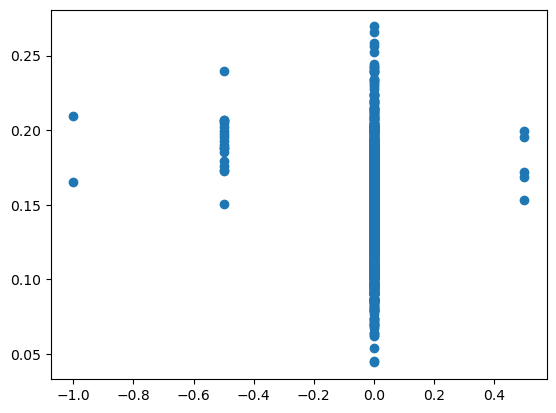

In [16]:
plt.figure()
plt.scatter(best_fits['OpM'], best_fits['distance'])

Text(0.5, 1.0, 'Epsilon SD')

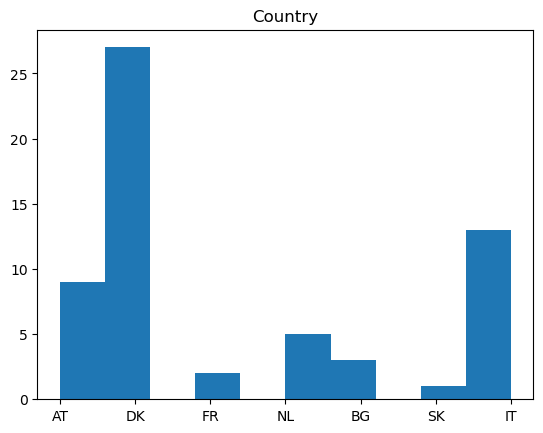

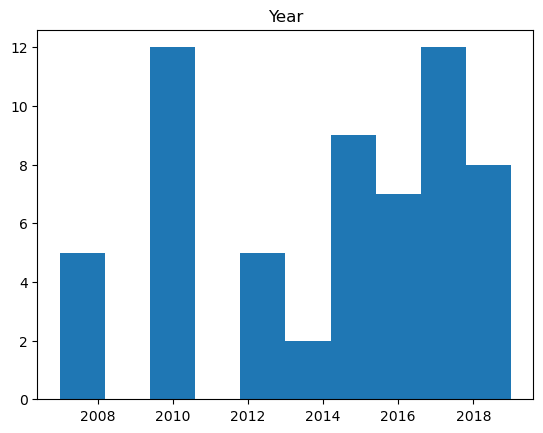

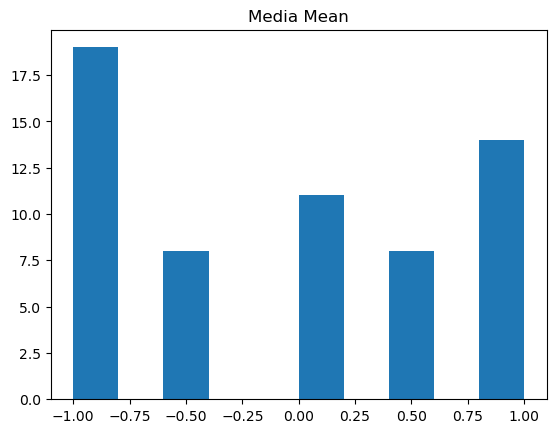

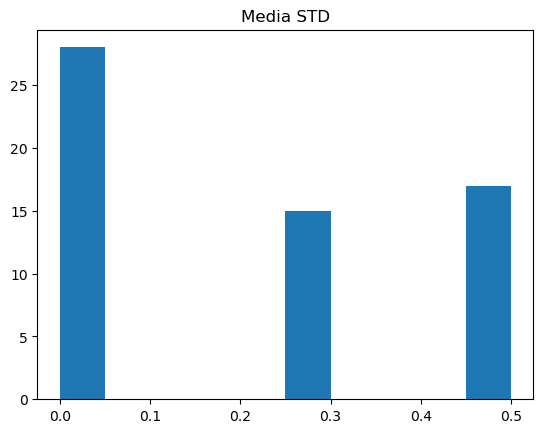

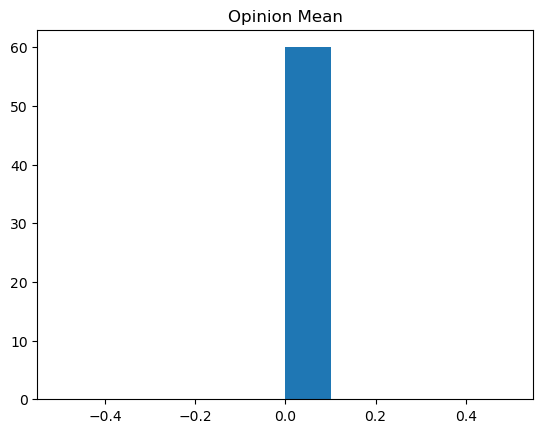

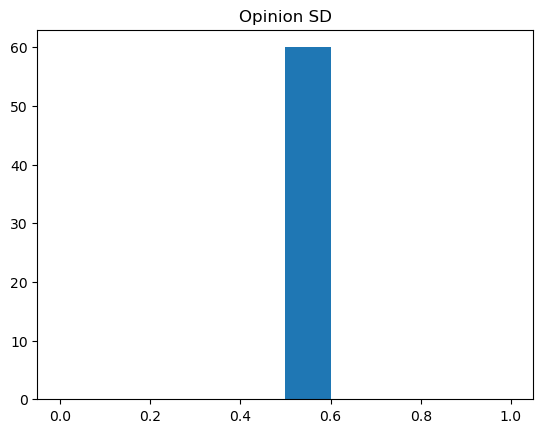

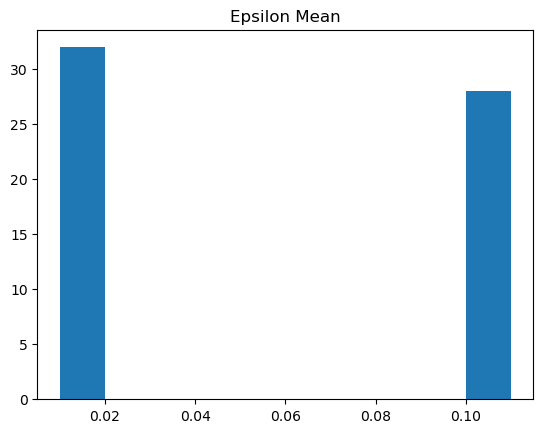

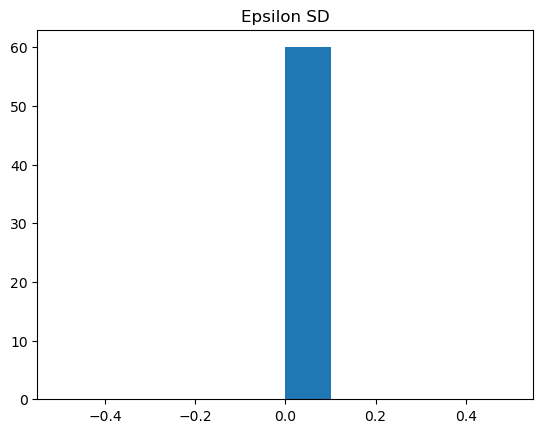

In [19]:
# Taking the set of k best fits to see if there's a systematic effect of any of the variables
k_smallest = (best_fits.nsmallest(60, 'distance'))

#Plotting histograms of some variable among these runs (and assuming a uniformity therein) to see if there are any biases
plt.figure()
plt.hist(k_smallest['country'], align = 'mid')
plt.title("Country")
plt.figure()
plt.hist(k_smallest['year'])
plt.title("Year")
plt.figure()
plt.hist(k_smallest['MedM'])
plt.title("Media Mean")
plt.figure()
plt.hist(k_smallest['MedSD'])
plt.title("Media STD")
plt.figure()
plt.hist(k_smallest['OpM'])
plt.title("Opinion Mean")
plt.figure()
plt.hist(k_smallest['OpSD'])
plt.title("Opinion SD")
plt.figure()

plt.hist(k_smallest['epsM'])
plt.title("Epsilon Mean")
plt.figure()

plt.hist(k_smallest['epsSD'])
plt.title("Epsilon SD")

        sim_index country  year  epsM  epsSD  OpM  OpSD  MedM  MedSD  distance
298458       1286      CY  2012  0.11   0.00  0.0   0.5   0.0   0.00  0.269563
192666        830      CY  2012  0.11   0.25  0.0   0.5  -1.0   0.00  0.265668
351354       1514      CY  2012  0.21   0.25  0.0   0.5   1.0   0.00  0.258688
298456       1286      CY  2007  0.11   0.00  0.0   0.5   0.0   0.00  0.256678
298547       1286      SI  2014  0.11   0.00  0.0   0.5   0.0   0.00  0.252550
38152         164      CY  2007  0.01   0.25  0.0   0.5   1.0   0.00  0.244546
36155         155      SI  2014  0.01   0.25  0.0   0.5  -1.0   0.00  0.242926
194758        839      CY  2017  0.11   0.25  0.0   0.5   1.0   0.00  0.242076
297147       1280      RO  2014  0.11   0.00  0.0   0.5  -1.0   0.00  0.241634
297067       1280      CY  2014  0.11   0.00  0.0   0.5  -1.0   0.00  0.240727
453664       1955      CY  2007  0.21   0.00  0.0   0.5  -1.0   0.00  0.240040
6227           26      SI  2014  0.01   0.25 -0.5   

Text(0.5, 1.0, 'e SD')

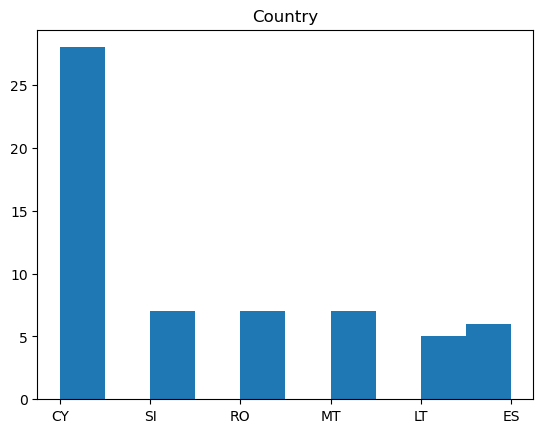

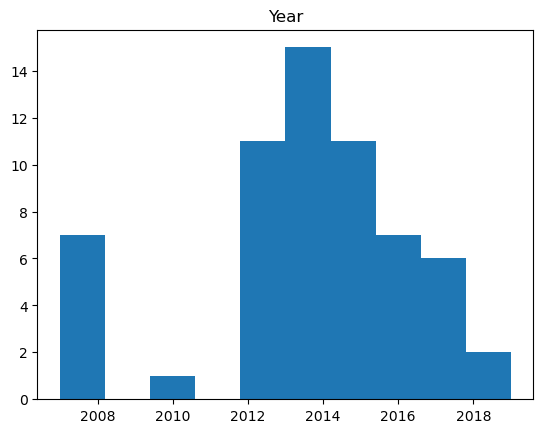

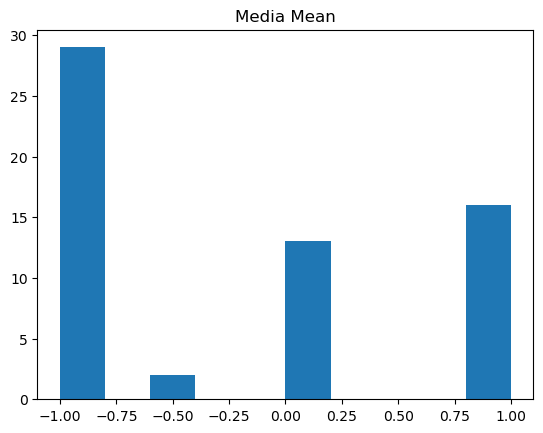

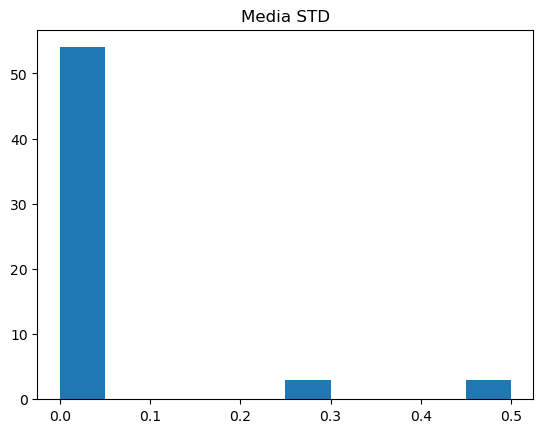

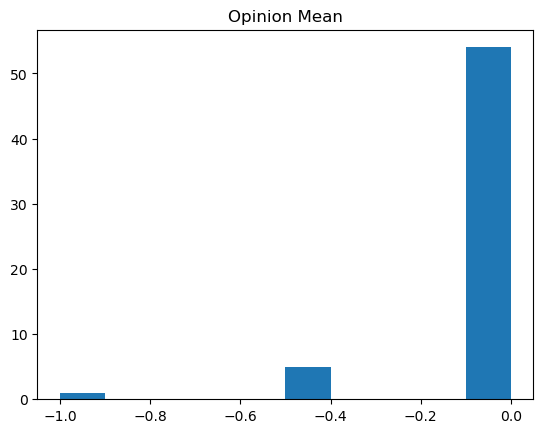

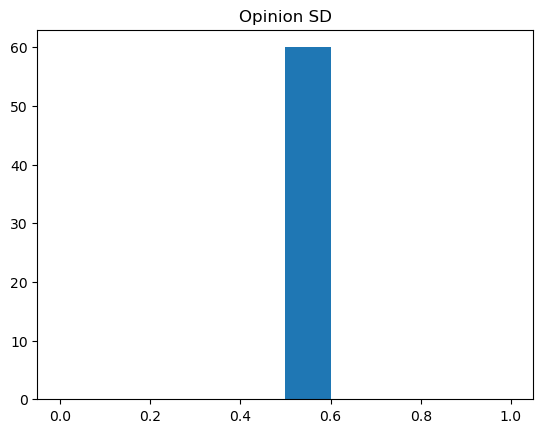

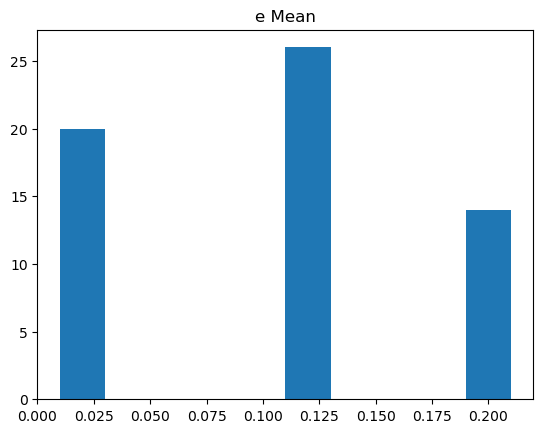

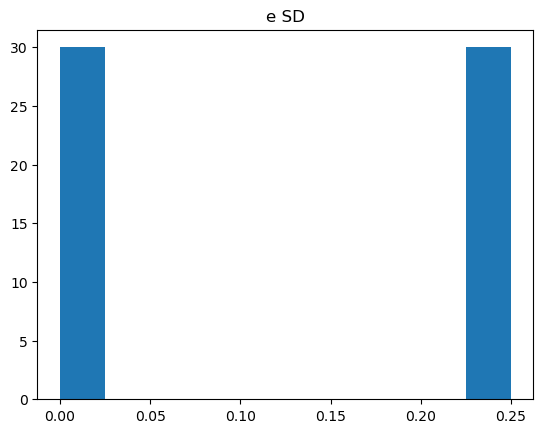

In [21]:
# Taking the set of k best fits to see if there's a systematic effect of any of the variables
k_largest = (best_fits.nlargest(60, 'distance'))
print(k_largest)
#Plotting histograms of some variable among these runs (and assuming a uniformity therein) to see if there are any biases
plt.figure()
plt.hist(k_largest['country'], align = 'mid')
plt.title("Country")
plt.figure()
plt.hist(k_largest['year'])
plt.title("Year")
plt.figure()
plt.hist(k_largest['MedM'])
plt.title("Media Mean")
plt.figure()
plt.hist(k_largest['MedSD'])
plt.title("Media STD")
plt.figure()
plt.hist(k_largest['OpM'])
plt.title("Opinion Mean")
plt.figure()
plt.hist(k_largest['OpSD'])
plt.title("Opinion SD")

plt.figure()
plt.hist(k_largest['epsM'])
plt.title("e Mean")
plt.figure()
plt.hist(k_largest['epsSD'])
plt.title("e SD")

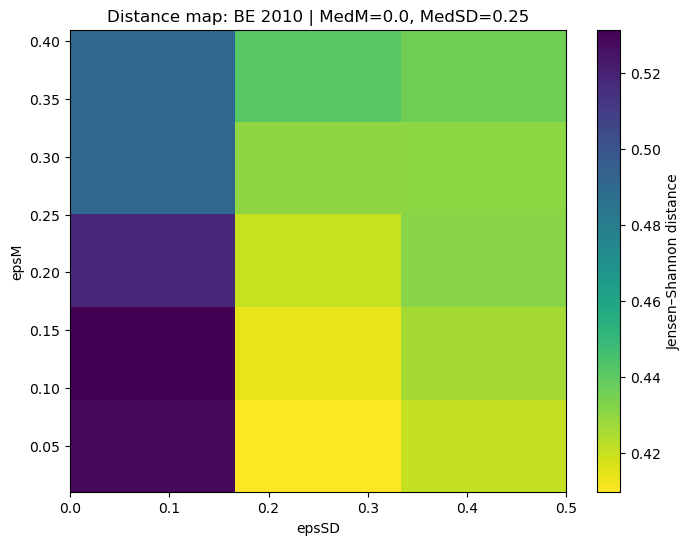

In [24]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

# Select target survey distribution
country = "BE"
year = 2010

survey_row = survey_df[(survey_df['country'] == country) & 
                       (survey_df['year'] == year)].iloc[0]
survey_dist = np.array(survey_row['binned_distribution_5_6clubbed'], dtype=float)

# Compute distances for all simulations
distances = []
for idx, row in simulations_df.iterrows():
    sim_dist = np.array(row['binned_distributions_5_6clubbed'], dtype=float)
    dist = jensenshannon(sim_dist, survey_dist)
    distances.append(dist)

simulations_df['distance'] = distances

# Example heatmap: epsM vs epsSD, fixing MedM and MedSD
fixed_MedM = 0.0
fixed_MedSD = 0.25

subset = simulations_df[(simulations_df['MedM'] == fixed_MedM) &
                         (simulations_df['MedSD'] == fixed_MedSD)]

pivot = subset.pivot_table(index='epsM', columns='epsSD', values='distance')

plt.figure(figsize=(8,6))
im = plt.imshow(pivot.values, origin='lower', 
                extent=[pivot.columns.min(), pivot.columns.max(), 
                        pivot.index.min(), pivot.index.max()],
                aspect='auto', cmap='viridis_r')
plt.colorbar(im, label='Jensen–Shannon distance')
plt.xlabel('epsSD')
plt.ylabel('epsM')
plt.title(f'Distance map: {country} {year} | MedM={fixed_MedM}, MedSD={fixed_MedSD}')
plt.show()


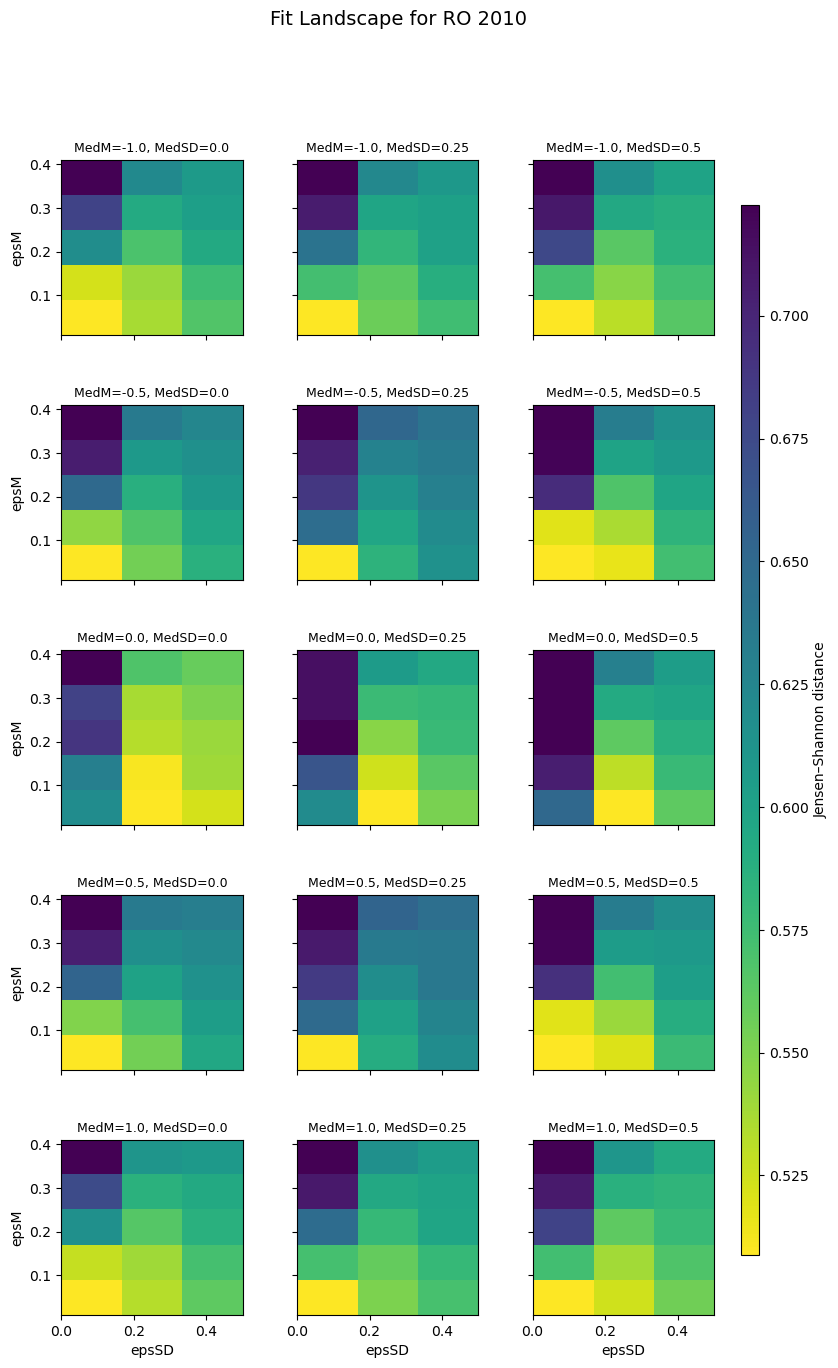

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

# ---- Select target survey distribution ----
country = "RO"
year = 2010
survey_row = survey_df[(survey_df['country'] == country) & 
                       (survey_df['year'] == year)].iloc[0]
survey_dist = np.array(survey_row['binned_distribution_5_6clubbed'], dtype=float)

# ---- Compute distances for all simulations ----
distances = []
for idx, row in simulations_df.iterrows():
    sim_dist = np.array(row['binned_distributions_5_6clubbed'], dtype=float)
    dist = jensenshannon(sim_dist, survey_dist)
    distances.append(dist)

simulations_df['distance'] = distances

# ---- Get unique sorted parameter values ----
medM_vals = sorted(simulations_df['MedM'].unique())
medSD_vals = sorted(simulations_df['MedSD'].unique())

# ---- Set up subplot grid ----
fig, axes = plt.subplots(len(medM_vals), len(medSD_vals), 
                         figsize=(3*len(medSD_vals), 3*len(medM_vals)),
                         sharex=True, sharey=True)

if len(medM_vals) == 1 and len(medSD_vals) == 1:
    axes = np.array([[axes]])  # force 2D array for indexing
elif len(medM_vals) == 1:
    axes = axes[np.newaxis, :]
elif len(medSD_vals) == 1:
    axes = axes[:, np.newaxis]

# ---- Loop over panels ----
for i, medM in enumerate(medM_vals):
    for j, medSD in enumerate(medSD_vals):
        ax = axes[i, j]
        subset = simulations_df[(simulations_df['MedM'] == medM) &
                                (simulations_df['MedSD'] == medSD)]
        
        pivot = subset.pivot_table(index='epsM', columns='epsSD', values='distance')
        im = ax.imshow(pivot.values, origin='lower',
                       extent=[pivot.columns.min(), pivot.columns.max(), 
                               pivot.index.min(), pivot.index.max()],
                       aspect='auto', cmap='viridis_r')
        
        if i == len(medM_vals)-1:
            ax.set_xlabel('epsSD')
        if j == 0:
            ax.set_ylabel('epsM')
        ax.set_title(f"MedM={medM}, MedSD={medSD}", fontsize=9)

# ---- Add colorbar ----
fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.4)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Jensen–Shannon distance')

plt.suptitle(f"Fit Landscape for {country} {year}", fontsize=14)
plt.savefig("colorplot.png",dpi=200)
plt.show()
